In [2]:
pip install pandas_bokeh

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import pandas_bokeh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.utils import shuffle
from tqdm import tqdm
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## 1. Data initialization/preprocessing

In [4]:
#Select the directory with dataframe and images
base_dir  = '/kaggle/input/brain-tumor/'
os.chdir(base_dir)
df = pd.read_csv("Brain Tumor.csv")[['Image', 'Class']]
print(df.shape)

(3762, 2)


In [5]:
def split_size(df, size):
    return int(size * len(df))

In [6]:
def split_array_labels(arr_image, arr_label):
    arr_image_0 = arr_image[np.where(arr_label==0)]
    arr_image_1 = arr_image[np.where(arr_label==1)]
    return {'0':arr_image_0, '1':arr_image_1}

In [7]:
#Create empty directories for each image set
def data_empty_directories(base_dir):
    check_exist_path = os.path.join(base_dir, 'DATA')
    if os.path.isdir(check_exist_path):
        shutil.rmtree(check_exist_path)
        print("Remove old directories")
    for label in ['0','1']:
        training_dir = os.path.join(base_dir, 'DATA', 'training', label)
        validation_dir = os.path.join(base_dir, 'DATA', 'validation', label)
        testing_dir = os.path.join(base_dir, 'DATA', 'testing', label)
        os.makedirs(training_dir)
        os.makedirs(validation_dir)
        os.makedirs(testing_dir)
    print(f"Created empty training, validation and testing directories")

In [8]:
split_index_1 = split_size(df, 0.8)
split_index_2 = split_size(df, 0.9)

train_labels = df['Class'].values[:split_index_1]
train_file_names = df['Image'].values[:split_index_1]

val_labels = df['Class'].values[split_index_1:split_index_2]
val_file_names = df['Image'].values[split_index_1:split_index_2]

test_labels = df['Class'].values[split_index_2:]
test_file_names = df['Image'].values[split_index_2:]

In [9]:
train_arr_dict = split_array_labels(train_file_names, train_labels)
val_arr_dict = split_array_labels(val_file_names, val_labels)
test_arr_dict = split_array_labels(test_file_names, test_labels)

In [10]:
data_empty_directories('/kaggle/working')

Created empty training, validation and testing directories


In [11]:
def split_data(SOURCE_DIR, train_arr_dict, val_arr_dict, test_arr_dict):
    def copy_files(file_names, label, dest_dir):
        for file_name in file_names:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join('/kaggle/working', 'DATA', dest_dir, label, file_name)
            copyfile(source, destination)
    for label in tqdm(['0', '1']):
        copy_files(train_arr_dict[label], label, 'training')
        copy_files(val_arr_dict[label], label, 'validation')
        copy_files(test_arr_dict[label], label, 'testing')
    print("Created training, validation, and testing directories containing images")
    
split_data(base_dir,train_arr_dict,val_arr_dict,test_arr_dict)

100%|██████████| 2/2 [00:28<00:00, 14.25s/it]

Created training, validation, and testing directories containing images


In [12]:
base_dir  = '/kaggle/working/DATA'
os.chdir(base_dir)

mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
df_samples = pd.DataFrame({'Train Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})
df_samples_pivot = df_samples.pivot(index='Train Test', columns='Labels', values='Number of Items').reset_index()

In [13]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [14]:
df_samples_pivot.plot_bokeh(
    kind='bar',
    x='Train Test',
    y=['0', '1'],
    xlabel='data category',
    ylabel='amount',
    title='Number of Images Per Category Label'
)

Figure(id='1039', ...)

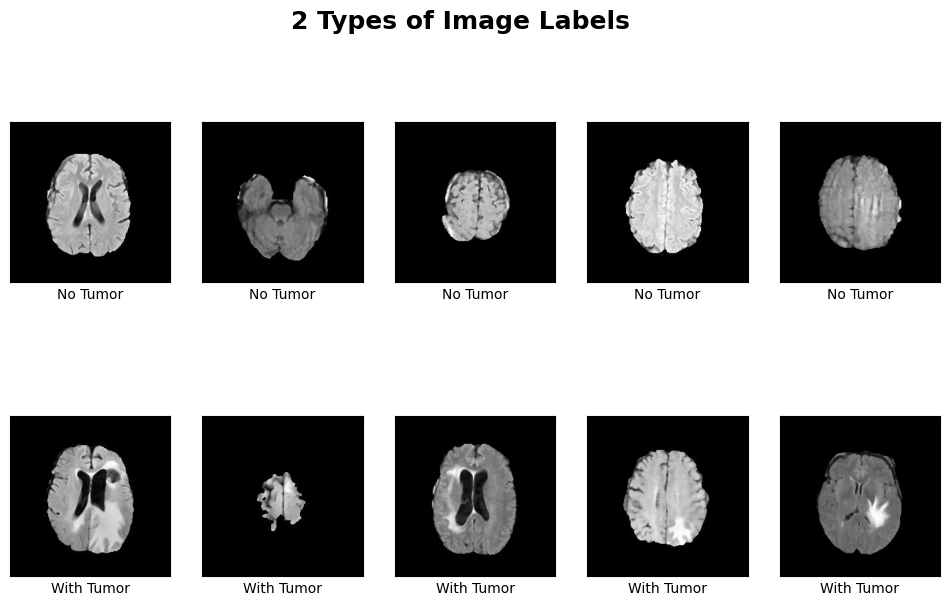

In [15]:
vis_images = vis_images[:10]
vis_labels = vis_labels[:10]
plt.figure(figsize=(12, 7))
for i in range(len(vis_labels)):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    if vis_labels[i] == '0':
        my_label = 'No Tumor'
    elif vis_labels[i] == '1':
        my_label = 'With Tumor'
    plt.xlabel(my_label)
    plt.suptitle("2 Types of Image Labels", fontsize=18, fontweight='bold')
plt.show()

In [135]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    train_datagen = ImageDataGenerator(
        rescale=1./127.5,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=32,
        class_mode='binary',
        target_size=(150, 150)
    )
    valid_or_test_datagen = ImageDataGenerator(rescale=1./127.5)
    validation_generator = valid_or_test_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        class_mode='binary',
        target_size=(150, 150)
    )
    test_generator = valid_or_test_datagen.flow_from_directory(
        directory=TEST_DIR,
        batch_size=32,
        class_mode='binary',
        target_size=(150, 150)
    )
    return train_generator, validation_generator, test_generator

In [136]:
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
testing_dir = os.path.join(base_dir, 'testing')
print(testing_dir)

/kaggle/working/DATA/testing


In [137]:
#Create train/test/validation sets of images
train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, testing_dir)

Found 3009 images belonging to 2 classes.
Found 376 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


## 2. Models building and training

In [50]:
import os
from functools import partial
from collections import namedtuple

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD

In [52]:
PreparedModel = namedtuple('PreparedModel', ['name', 'keras_pretrained', 'optimizer'])

In [53]:
def get_keras_pretrained(keras_model):
    pretrained = keras_model(
        input_shape=(150, 150, 3),
        weights='imagenet',
        include_top=False
    )
    pretrained.trainable = False
    return pretrained

In [54]:
prepared_VGG16 = PreparedModel('VGG16', get_keras_pretrained(VGG16), 'adam')
prepared_MobileNetV2 = PreparedModel('MobileNetV2', get_keras_pretrained(MobileNetV2), 'adam')
prepared_InceptionV3 = PreparedModel('InceptionV3', get_keras_pretrained(InceptionV3), 'adam')
prepared_ResNet50 = PreparedModel('ResNet50', get_keras_pretrained(ResNet50), 'adam')

In [71]:
# models = [prepared_VGG16, prepared_MobileNetV2, prepared_InceptionV3, prepared_ResNet50]
models = [prepared_ResNet50]

In [67]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    return model

# for model_i in models:
#     pre_trained_model = model_i.keras_pretrained
#     last_output = pre_trained_model.output
#     num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])
#     print(f"There are {num_trainable_params:,} trainable parameters in this model.")
#     print(f"The pretrained model has type: {type(pre_trained_model)}")
#     model = transfer_learning(last_output, pre_trained_model)
#     model.summary()

In [57]:
# model = transfer_learning(last_output, pre_trained_model)
# print(f"Total Trainable Variables: {len(model.trainable_variables)}")

In [58]:
ACCURACY_THRESHOLD = 0.99
class TresholdStopping(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(TresholdStopping, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs['val_accuracy']
        if accuracy >= self.point:
            self.model.stop_training = True
treshold_stopping = TresholdStopping(ACCURACY_THRESHOLD)

In [72]:
for model_i in models:
    pre_trained_model = model_i.keras_pretrained
    last_output = pre_trained_model.output
    num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])
    print(f"There are {num_trainable_params:,} trainable parameters in this model.")
    print(f"The pretrained model has type: {type(pre_trained_model)}")
    model = transfer_learning(last_output, pre_trained_model)
#     model.summary()

    print(f"Total Trainable Variables: {len(model.trainable_variables)}")

    model.compile(
          loss='binary_crossentropy',
          optimizer=model_i.optimizer,
          metrics=['accuracy'],

        )

    checkpointing = ModelCheckpoint(
        filepath=f'/kaggle/working/{model_i.name}',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )

    log_saving = CSVLogger(f'/kaggle/working/{model_i.name}-log.csv', append=True, separator=';')

    print(f'STARTED TRAINIG OF {model_i.name} PREPARED MODEL')

    model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=[checkpointing, log_saving, treshold_stopping]
    )

    model.save(f'/kaggle/working/{model_i.name}_trained.hdf5')

    print(f'TRAINIG OF {model_i.name} COMPLETED')
    print('------------------------------')

There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.engine.functional.Functional'>
Total Trainable Variables: 4
STARTED TRAINIG OF ResNet50 PREPARED MODEL
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.7335
Epoch 1: val_accuracy improved from -inf to 0.74734, saving model to /kaggle/working/ResNet50
95/95 [==============================] - 25s 223ms/step - loss: 1.2351 - accuracy: 0.7335 - val_loss: 0.6167 - val_accuracy: 0.7473
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8222
Epoch 2: val_accuracy did not improve from 0.74734
95/95 [==============================] - 19s 204ms/step - loss: 0.4286 - accuracy: 0.8222 - val_loss: 0.7549 - val_accuracy: 0.6968
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8282
Epoch 3: val_accuracy did not improve from 0.74734
95/95 [==============================] - 19s 196ms/step - loss

In [ ]:
base_model = prepared_MobileNetV2.keras_pretrained
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
print(f"Total Trainable Variables: {len(model.trainable_variables)}")

In [ ]:
last_output = base_model.output
model = transfer_learning(last_output, base_model)

name = "MobileNetV2_fine_tuned"

model.compile(
      loss='binary_crossentropy',
      optimizer=base_model.optimizer,
      metrics=['accuracy'],

    )

checkpointing = ModelCheckpoint(
    filepath=f'/kaggle/working/{name}',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

log_saving = CSVLogger(f'/kaggle/working/{name}-log.csv', append=True, separator=';')

print(f'STARTED TRAINIG OF {name} PREPARED MODEL')

model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpointing, log_saving, treshold_stopping]
)

model.save(f'/kaggle/working/{name}_trained.hdf5')

print(f'TRAINIG OF {name} COMPLETED')
print('------------------------------')

In [92]:
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
def model(input_shape):
#     res_conv = ResNet50(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape, pooling=None)
    model = Sequential()
    
    model.add(Input(shape=input_shape))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
#     model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))    # Never use sigmoid for binary classification
    
    return model
simple_CNN_model = model(input_shape = (150, 150, 3))

In [94]:
simple_CNN_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [96]:
name = 'SimpleCNN'

checkpointing = ModelCheckpoint(
    filepath=f'/kaggle/working/{name}',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

log_saving = CSVLogger(f'/kaggle/working/{name}-log.csv', append=True, separator=';')
print(f'{name} IS READY FOR TRAINIG:')
#simple_CNN_model.summary()

print(f'STARTED TRAINIG OF {name} FROM SCRATCH MODEL')

simple_CNN_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpointing, log_saving]
)
simple_CNN_model.save(f'/kaggle/working/{name}_trained.hdf5')

print(f'TRAINIG OF {name} COMPLETED')
print('------------------------------')

SimpleCNN IS READY FOR TRAINIG:
STARTED TRAINIG OF SimpleCNN FROM SCRATCH MODEL
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8744
Epoch 1: val_accuracy improved from -inf to 0.73138, saving model to /kaggle/working/SimpleCNN
95/95 [==============================] - 17s 182ms/step - loss: 0.2989 - accuracy: 0.8744 - val_loss: 0.6251 - val_accuracy: 0.7314
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8750
Epoch 2: val_accuracy did not improve from 0.73138
95/95 [==============================] - 17s 175ms/step - loss: 0.2907 - accuracy: 0.8750 - val_loss: 0.7302 - val_accuracy: 0.6888
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8737
Epoch 3: val_accuracy did not improve from 0.73138
95/95 [==============================] - 17s 181ms/step - loss: 0.2972 - accuracy: 0.8737 - val_loss: 0.6815 - val_accuracy: 0.7048
Epoch 4/50
95/95 [===========================

In [ ]:
# pretrained_cnn = keras.models.load_model('/kaggle/working/models/VGG16/VGG16_trained.hdf5')
# loss, accuracy = pretrained_cnn.evaluate(test_generator)
# print('Test accuracy :', accuracy)

In [99]:
! git clone https://github.com/sherwood01v/brain_tumor_detection.git

fatal: destination path 'brain_tumor_detection' already exists and is not an empty directory.


In [100]:
os.chdir(os.path.join('/kaggle', 'working', 'DATA', 'brain_tumor_detection'))
model_names = ('InceptionV3', 'MobileNetV2', 'ResNet50', 'VGG16')
model_paths = (os.path.join(name, f'{name}-log.csv') for name in model_names)

In [102]:
def collect_logs(model_names: tuple, model_paths: tuple, df: pd.DataFrame = None, sep:str = ';') -> pd.DataFrame:
    for name, path in zip(model_names, model_paths):

            if df is None:
                df = pd.read_csv(path, sep=sep)
                df['model'] = name
                df.set_index(['model', 'epoch'], inplace=True)
                continue
                
            log = pd.read_csv(path, sep=sep)
            log['model'] = name
            log.set_index(['model', 'epoch'], inplace=True)

            df = pd.concat([df, log])

    return df

In [103]:
df = collect_logs(model_names, model_paths)
df.head()

accuracy      loss  val_accuracy  val_loss
model       epoch                                            
InceptionV3 0      0.803589  4.249010      0.813830  0.958074
            1      0.854769  0.457667      0.864362  0.301440
            2      0.867065  0.334409      0.875000  0.289141
            3      0.888667  0.287570      0.864362  0.325055
            4      0.883682  0.306347      0.843085  0.388043

In [104]:
df.shape

(235, 4)

In [105]:
print('Final validation accuracy:')
val_acc = df.groupby('model').val_accuracy.max()
val_acc

Final validation accuracy:


model
InceptionV3    0.909574
MobileNetV2    0.922872
ResNet50       0.779255
VGG16          0.904255
Name: val_accuracy, dtype: float64

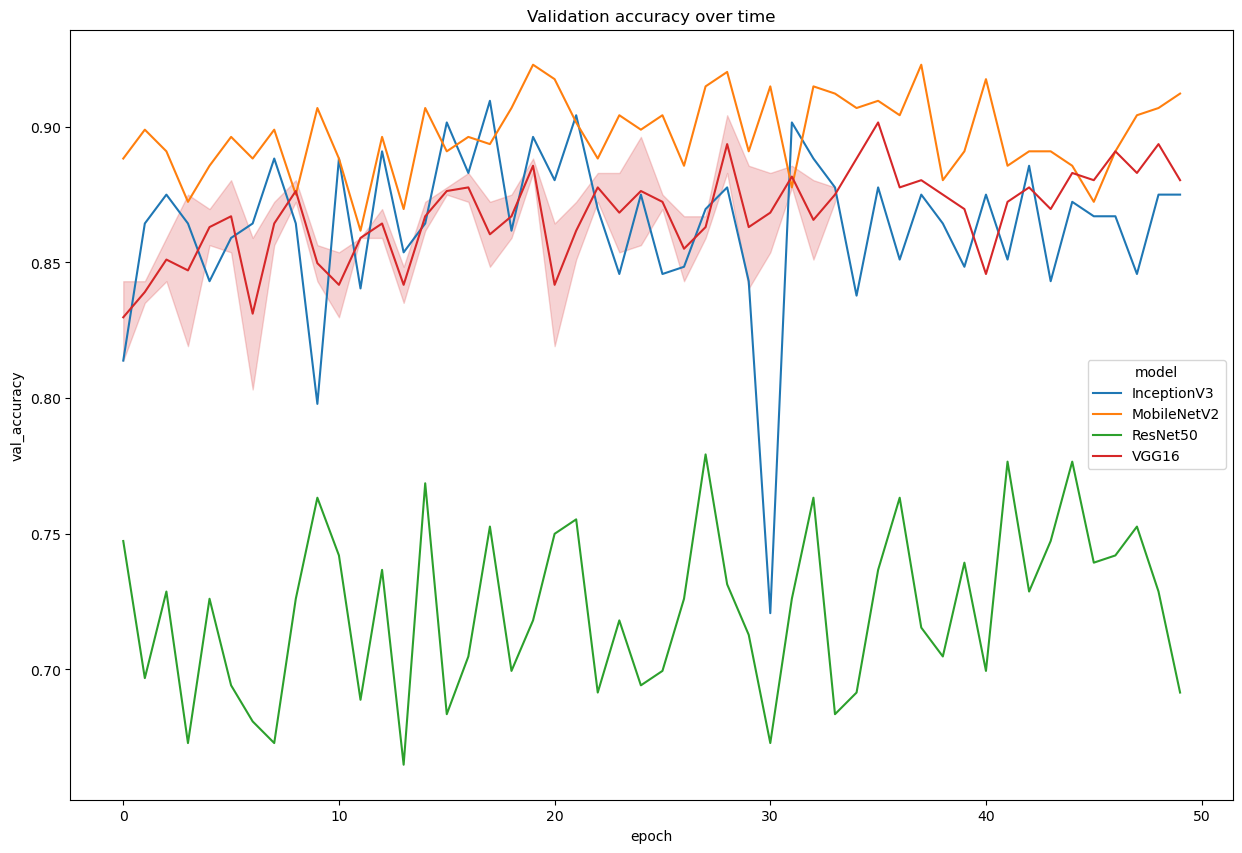

In [108]:
import seaborn as sns
sns.lineplot(data=df, x='epoch', y='val_accuracy', hue='model')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title('Validation accuracy over time')
plt.show()

In [148]:
import keras
pretrained_cnn = keras.models.load_model('/kaggle/working/ResNet50_trained.hdf5')
loss, accuracy = pretrained_cnn.evaluate(test_generator)
print('Test accuracy :', accuracy)

12/12 [==============================] - 2s 76ms/step - loss: 0.5860 - accuracy: 0.7586
Test accuracy : 0.7586206793785095


In [162]:
selected_paths = [] ; selected_labels = []
testing_path_0 = os.path.join(base_dir, 'testing', '0')
for x in random.sample(os.listdir(testing_path_0),10):
    selected_paths.append(os.path.join(testing_path_0, x))
    selected_labels.append(0)

testing_path_1 = os.path.join(base_dir, 'testing', '1')
for x in random.sample(os.listdir(testing_path_1),10):
    selected_paths.append(os.path.join(testing_path_1, x))
    selected_labels.append(1)

In [167]:
from sklearn.utils import shuffle
X, y = shuffle(selected_paths, selected_labels, random_state=0)

In [173]:
predicted_array = []
y_true_array = []
for vis_image, y_true in zip(X, y):
    img = image.load_img(vis_image, target_size=(150, 150))
    x = image.img_to_array(img)
    x /= 127.5
    x = np.expand_dims(x, axis=0)
    preprocess_images = np.vstack([x])
    classes = pretrained_cnn.predict(preprocess_images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])
    if classes[0]>0.5:
        predicted_array.append(1)
        predicted_label = 1
    else:
        predicted_array.append(0)
        predicted_label =0
    y_true_array.append(y_true)
#     plt.title(f'True Label: {y_true} \n Predicted Label: {predicted_label} with a {100 * np.max(score):.2f} percent confidence.')
#     plt.imshow(img)
#     plt.show()
confusion = confusion_matrix(y_true_array, predicted_array)
confusion_df = pd.DataFrame(confusion, index=test_generator.class_indices, columns=test_generator.class_indices)
print('Confusion Matrix:')
print(confusion_df)

1/1 [==============================] - 0s 24ms/step
Confusion Matrix:
   0  1
0  9  1
1  2  8


In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.6)

    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

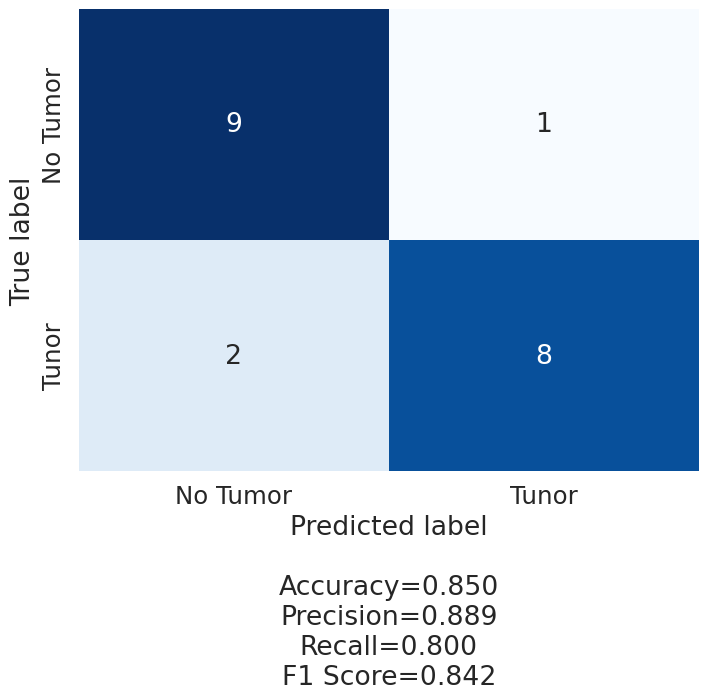

In [174]:
categories = ["No Tumor", "Tunor"]
make_confusion_matrix(confusion, figsize=(8,6), cbar=False,categories=categories)